In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from pmdarima.utils import tsdisplay, autocorr_plot, decomposed_plot, plot_acf, plot_pacf

Importação e tratamento de dados

In [2]:
df = pd.read_csv('datasets/Ibovespa4anos.csv',parse_dates=['Data'])
display(df.head())

C:\Users\rpjun\AppData\Local\Temp\ipykernel_13436\3582083498.py:1: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv('datasets/Ibovespa4anos.csv',parse_dates=['Data'])


,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,2024-05-24,124.306,124.731,125.257,124.259,"9,21M","-0,34%"
1,2024-05-23,124.729,125.650,125.665,124.431,"9,99M","-0,73%"
2,2024-05-22,125.650,127.412,127.412,125.524,"12,40M","-1,38%"
3,2024-05-21,127.412,127.754,128.272,127.205,"9,14M","-0,27%"
4,2024-05-20,127.751,128.151,128.730,127.488,"9,34M","-0,31%"


In [3]:
df_new = df.copy().drop(columns='Var%')

In [4]:
df_new.rename(columns={'Data':'ds','Último':'y','Abertura':'abertura','Máxima':'maxima','Mínima':'minima','Vol.':'volume'}, inplace=True)

In [5]:
df_new['volume'].fillna('0', inplace=True)

C:\Users\rpjun\AppData\Local\Temp\ipykernel_13436\2870134375.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_new['volume'].fillna('0', inplace=True)


In [6]:
df_new['volume'] = df_new['volume'].str.replace('M','',regex=False).str.replace(',','.',regex=False).astype(float)

In [7]:
df_new['volume'] = df_new['volume'] * 1_000_000

In [8]:
df_new['dia'] = df_new['ds'].dt.day
df_new['mes'] = df_new['ds'].dt.month
df_new['ano'] = df_new['ds'].dt.year
df_new['dia_semana']=df_new['ds'].dt.day_of_week

In [9]:
df_new.head()

,ds,y,abertura,maxima,minima,volume,dia,mes,ano,dia_semana
0,2024-05-24,124.306,124.731,125.257,124.259,9210000.0,24,5,2024,4
1,2024-05-23,124.729,125.650,125.665,124.431,9990000.0,23,5,2024,3
2,2024-05-22,125.650,127.412,127.412,125.524,12400000.0,22,5,2024,2
3,2024-05-21,127.412,127.754,128.272,127.205,9140000.0,21,5,2024,1
4,2024-05-20,127.751,128.151,128.730,127.488,9340000.0,20,5,2024,0


Visualização da relação de data(ds), valores de abertura, fechamento, valor mínimo e máximo

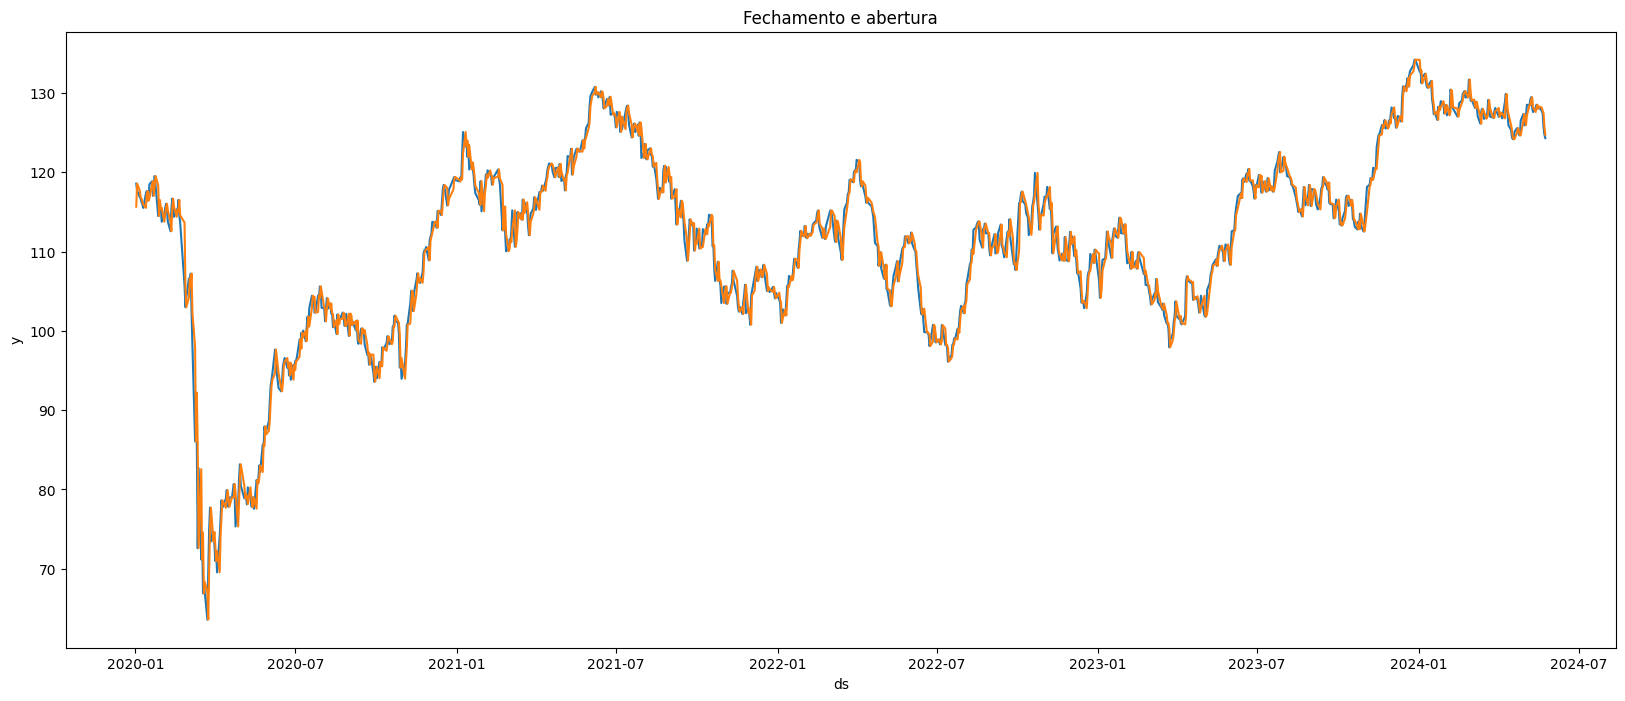

In [10]:
plt.figure(figsize=(20,8))
sns.lineplot(x='ds',y='y',data= df_new)
sns.lineplot(x='ds',y='abertura',data= df_new)
plt.title('Fechamento e abertura')
plt.show()

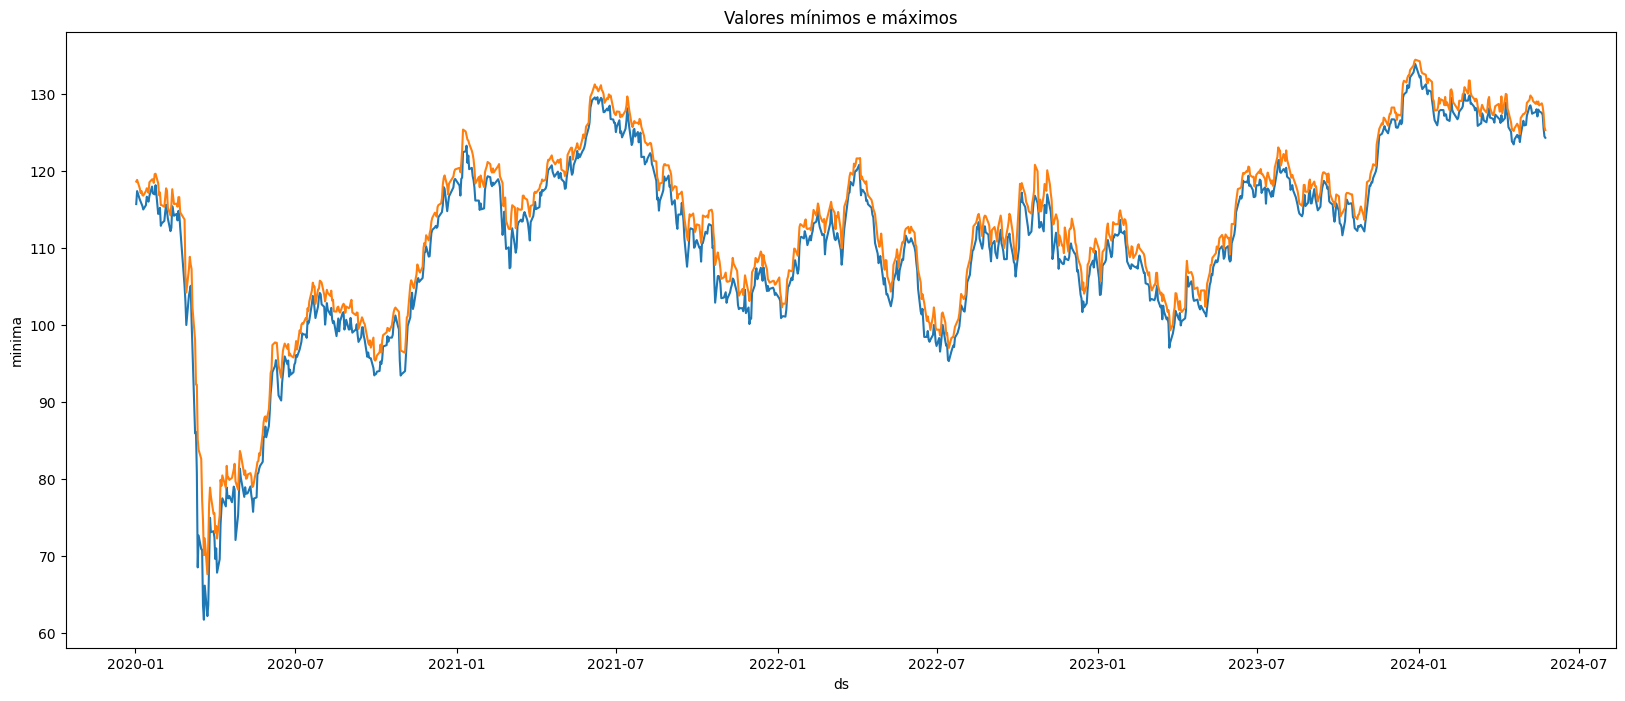

In [11]:
plt.figure(figsize=(20,8))
sns.lineplot(x='ds',y='minima',data= df_new)
sns.lineplot(x='ds',y='maxima',data= df_new)
plt.title('Valores mínimos e máximos')
plt.show()

Visualização da matriz de correlação

In [12]:
corr = df_new.corr()
corr.style.background_gradient(cmap='coolwarm')

,ds,y,abertura,maxima,minima,volume,dia,mes,ano,dia_semana
ds,1.000000,0.523256,0.521299,0.518928,0.528901,0.293878,0.009800,0.053163,0.974626,-0.002268
y,0.523256,1.000000,0.990687,0.996064,0.997377,-0.168139,-0.015876,-0.049136,0.527301,0.005961
abertura,0.521299,0.990687,1.000000,0.996627,0.994352,-0.168991,-0.007864,-0.055716,0.526687,0.009010
maxima,0.518928,0.996064,0.996627,1.000000,0.995746,-0.156899,-0.015209,-0.054554,0.524224,0.007700
minima,0.528901,0.997377,0.994352,0.995746,1.000000,-0.181163,-0.009494,-0.046414,0.532142,0.005551
volume,0.293878,-0.168139,-0.168991,-0.156899,-0.181163,1.000000,-0.057788,0.135556,0.260776,0.167084
dia,0.009800,-0.015876,-0.007864,-0.015209,-0.009494,-0.057788,1.000000,0.007940,-0.010643,-0.013736
mes,0.053163,-0.049136,-0.055716,-0.054554,-0.046414,0.135556,0.007940,1.000000,-0.170939,-0.005123
ano,0.974626,0.527301,0.526687,0.524224,0.532142,0.260776,-0.010643,-0.170939,1.000000,-0.000873
dia_semana,-0.002268,0.005961,0.009010,0.007700,0.005551,0.167084,-0.013736,-0.005123,-0.000873,1.000000


Criação do dataframe contendo apenas data e valor final

In [13]:
df_data = df_new[['ds','y']].set_index('ds')

In [14]:
df_data.sort_index(inplace=True)

Análise de sazonalidade, tendência e ruído

In [22]:
resultados = seasonal_decompose(df_data, period=30)

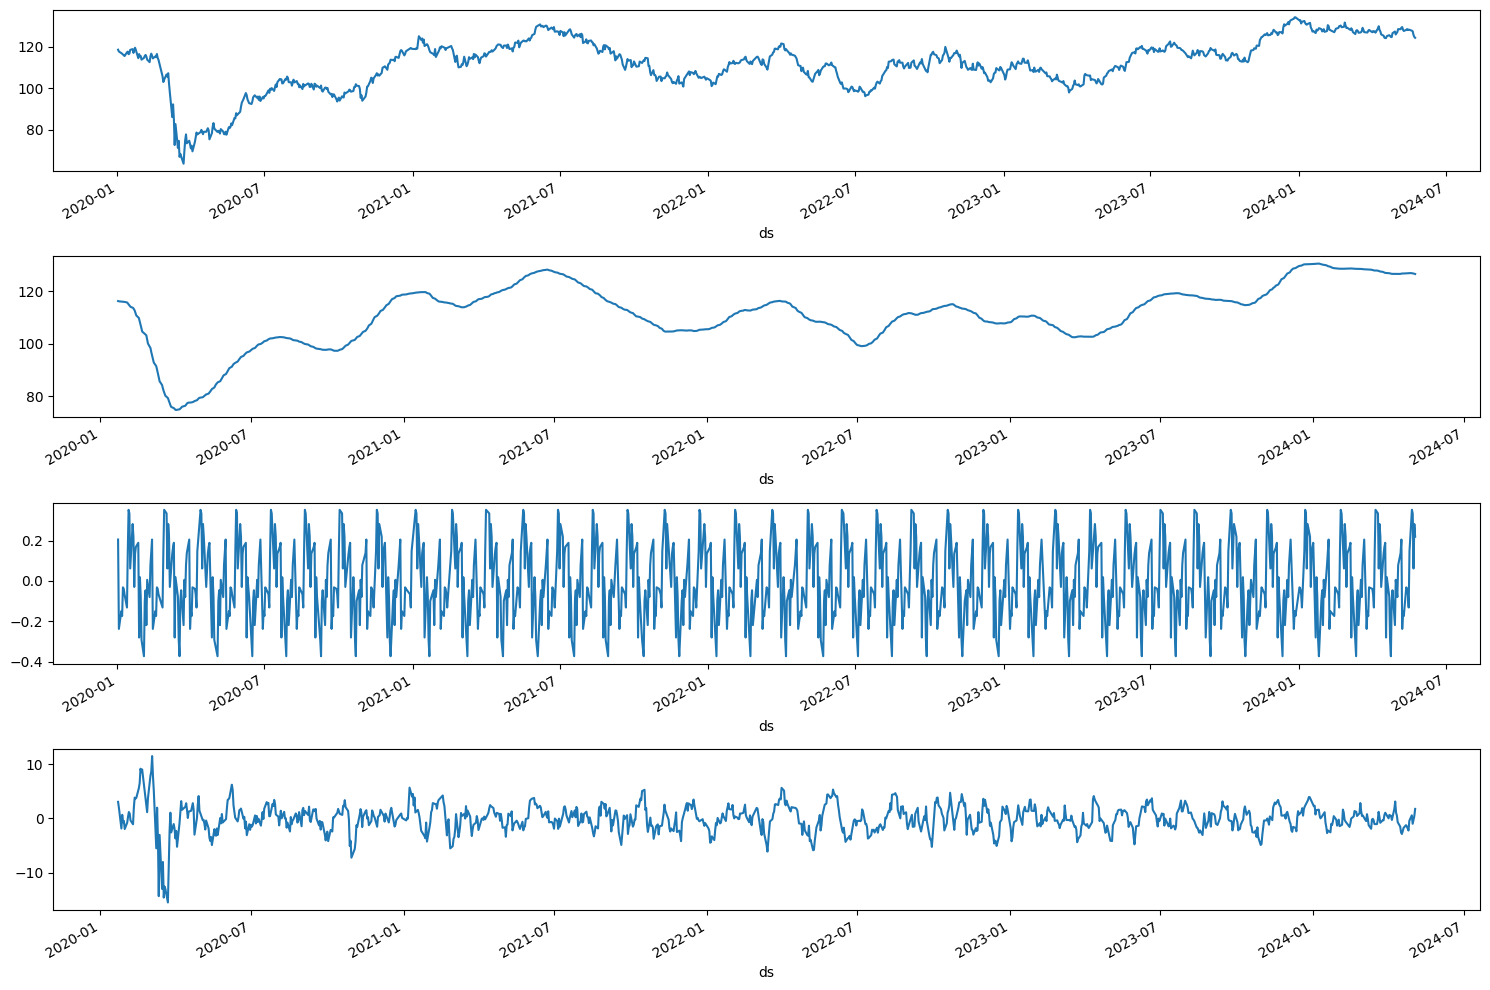

In [23]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(15,10))
resultados.observed.plot(ax=ax1)
resultados.trend.plot(ax=ax2)
resultados.seasonal.plot(ax=ax3)
resultados.resid.plot(ax=ax4)
plt.tight_layout()

Análise de dados estacionários e não=estacionários (pValue < 0.05)

In [17]:
x = df_data.y.values

In [18]:
result = adfuller(x)

print("teste ADF")
print(f'teste estatístico {result[0]}')
print(f"pValue {result[1]}")

for key, valor in result[4].items():
    print(f"Valores críticos")
    print(f"\t{key}:{valor}")

teste ADF
teste estatístico -2.378746212466041
pValue 0.14782520174554337
Valores críticos
	1%:-3.4363857496063455
Valores críticos
	5%:-2.8642050392821794
Valores críticos
	10%:-2.5681889563132314


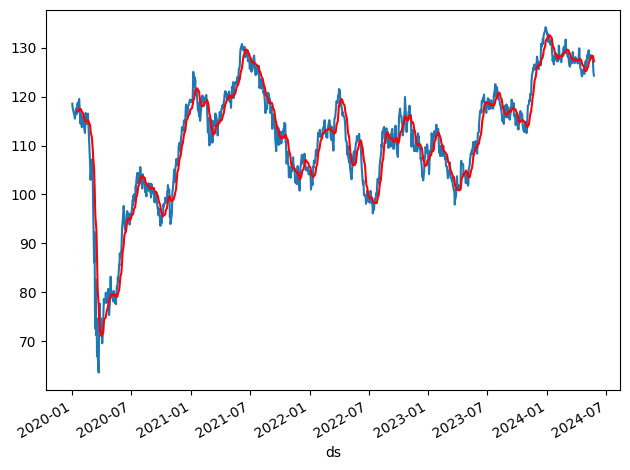

In [19]:
ma = df_data.rolling(12).mean()

fig, ax = plt.subplots()
df_data.plot(ax=ax,legend=False)
ma.plot(ax=ax, legend=False,color='r')
plt.tight_layout()

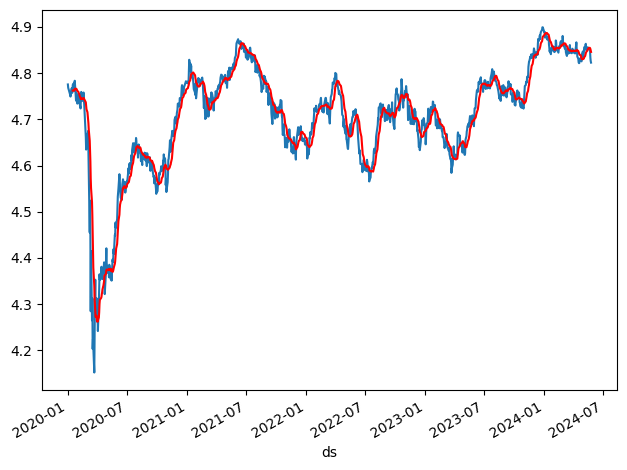

In [20]:
df_log = np.log(df_data)
ma_log = df_log.rolling(12).mean()

fig, ax = plt.subplots()
df_log.plot(ax=ax,legend=False)
ma_log.plot(ax=ax, legend=False,color='r')
plt.tight_layout()

c:\Users\rpjun\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\utils\visualization.py:220: FutureWarning: the 'unbiased' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


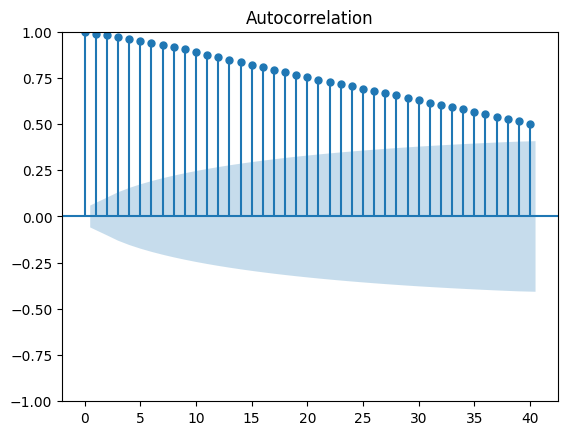

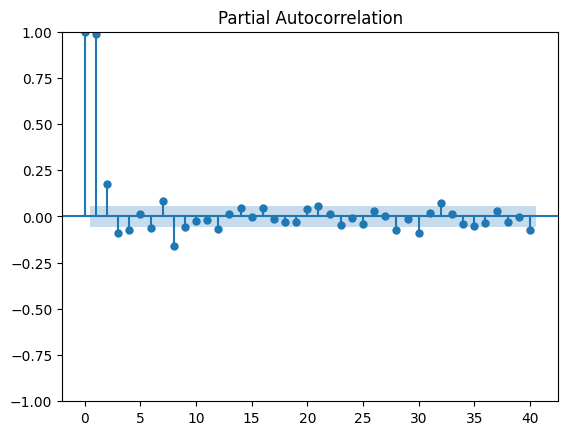

In [21]:
plot_acf(df_log['y'], lags=40, alpha=0.05)
plot_pacf(df_log['y'], lags=40, alpha=0.05)
plt.show()